In [1]:
#data loading
import pandas as pd
import zipfile

#predata = pd.read_csv('0transfers_nd_corr.csv', low_memory = False) 

In [2]:
#use this data loading due to memory error - remove after
import pandas as pd
predataf = pd.read_csv('2frauds_transfers.csv', low_memory = False, usecols = ['canal', 'operativa', 'entity', 'reference', 
                                                                              'trusted_indicator', 'iban_orig', 'iban_dest', 
                                                                              'amount', 'accountbalance', 'ipaddress', 
                                                                              'is_fraud', 'is_tablet', 'is_pc', 'is_mobile', 
                                                                              'is_touch', 'clientid', 'browser_family', 
                                                                              'os_family', 'hour', 'week', 'timestamp'])

predatanf = pd.read_csv('2nonfrauds_transfers_corr.csv', low_memory = False, usecols = ['canal', 'operativa', 'entity', 
                                                                                        'reference', 'trusted_indicator', 
                                                                                        'iban_orig', 'iban_dest', 'amount', 
                                                                                        'accountbalance', 'ipaddress', 
                                                                                        'is_fraud', 'is_tablet', 'is_pc', 
                                                                                        'is_mobile', 'is_touch', 'clientid', 
                                                                                        'browser_family', 'os_family', 'hour', 
                                                                                        'week', 'timestamp'], nrows = 8000000)  

predata = pd.concat([predataf, predatanf], ignore_index = True)  #nf = 15637832 and f = 569

In [2]:
#make sure the dataframes were well selected
counts = predata['is_fraud'].value_counts()
counts

0    8000000
1        569
Name: is_fraud, dtype: int64

In [3]:
#ratios of each class
counts / predata.shape[0]

0    0.999929
1    0.000071
Name: is_fraud, dtype: float64

In [4]:
#inicial number of columns and rows of the dataframe
predata.shape

(8000569, 21)

In [ ]:
#values that a column takes
#set(predata['cons_freq_ipaddress'])

In [ ]:
#how many different values the column has
#len(set(predata['cons_freq_ipaddress']))

In [ ]:
#view specific column by index
#predata.iloc[:, 12]

In [6]:
#visualize the whole output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
#create column weekday
predata['weekday'] = pd.to_datetime(predata['timestamp']).apply(lambda x: x.weekday())

In [6]:
#create column month
predata['month'] = pd.DatetimeIndex(predata['timestamp']).month

In [7]:
#drop column timestamp that was used for creating weekday and month
predata.drop(['timestamp'], axis = 1, inplace = True)

In [8]:
#renaming browsers
def assign_brws_fam(x):

    changes = {
        "m bot": "other",  #15
        "android": "other",  #104
        "1password": "other",  #57
        "chrome mobile": "chrome",  #735168
        "chrome mobile webview": "chrome",  #2681
        "mobile safari": "safari",  #338413
        "mobile safari ui/wkwebview": "safari",  #4190964
        "firefox mobile": "firefox"  #5515
    }

    if x in changes.keys():
        return changes[x]
    else:
        return x

predata["browser_family"] = predata["browser_family"].apply(lambda x: assign_brws_fam(x))

In [9]:
#renaming os 
def assign_os_fam(x):

    changes = {
        "windows phone": "windows",  #863
    }

    if x in changes.keys():
        return changes[x]
    else:
        return x

predata["os_family"] = predata["os_family"].apply(lambda x: assign_os_fam(x))

In [10]:
#remove spaces on browsers and os 
cols = ['os_family', 'browser_family']

for col in cols:
      predata[col] = predata[col].apply(lambda x: x.replace(' ', ''))

In [3]:
#make all lowercase
def convert_column_lower(column, df):
    df[column] = df[column].str.lower()
    
columns_to_lower = ['canal', 'operativa', 'browser_family', 'os_family', 'ipaddress']
for col in columns_to_lower:
    predata[col] = predata[col].str.lower()

In [12]:
#remove dots from ipaddress
predata['ipaddress'] = predata['ipaddress'].apply(lambda x: "".join(x.split(".")))

In [13]:
#merge is_tablet, is_pc, is_mobile on a new device column
#takes the 1st true that appears
def deviceselect(x): 
    #if True in tablet and touch
    if x['is_tablet'] and x['is_touch']:
       return 'ttablet'
    
    #if True in pc and touch
    if x['is_pc'] and x['is_touch']:
       return 'tpc'
    
    #if True in mobile and touch
    if x['is_mobile'] and x['is_touch']:
       return 'tmobile'

    #if True only in mobile
    if x['is_mobile']:
        return 'mobile'
    
    #if True only in pc
    if x['is_pc']:
        return 'pc'

    #if True only in tablet
    if x['is_tablet']:
        return 'tablet'  
    
    #if all false return otherd
    return 'otherd'                            
    
predata['device'] = predata.apply(deviceselect, axis = 1)

In [14]:
#drop columns that were merged on the new device column
predata.drop(['is_pc', 'is_tablet', 'is_mobile', 'is_touch'], axis = 1, inplace = True)  

In [15]:
#final number of columns and rows of the dataframe
predata.shape

(8000569, 19)

In [16]:
#final columns of the dataframe
predata.columns

Index(['canal', 'operativa', 'clientid', 'entity', 'reference',
       'trusted_indicator', 'iban_orig', 'iban_dest', 'amount',
       'accountbalance', 'ipaddress', 'is_fraud', 'browser_family',
       'os_family', 'hour', 'week', 'weekday', 'month', 'device'],
      dtype='object')

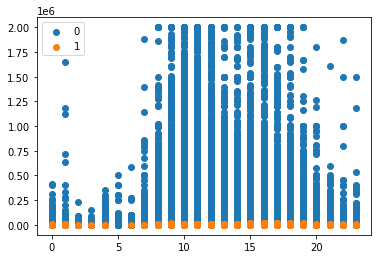

In [39]:
#plot the imbalanced dataset with scatter
from numpy import unique
from numpy import where
from matplotlib import pyplot 

def plot_dataset(X, y):
    
    #create scatter plot for samples from each class
    n_classes = len(unique(y))
    for class_value in range(n_classes):
        
        #get row indexes for samples with this class
        row_ix = where(y == class_value)[0]
        
        #create scatter plot of these samples
        pyplot.scatter(X.iloc[row_ix, 0], X.iloc[row_ix, 1], label = str(class_value))

    pyplot.legend()
    pyplot.show()
    
#target column
y = predata['is_fraud'] 

#columns with continuous values
X = predata[['hour', 'amount']]
       
plot_dataset(X, y)

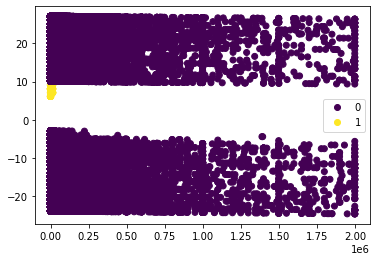

In [45]:
#plot the imbalanced dataset with PCA
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

#target column
y = predata['is_fraud'] 

#columns with continuous values
X = predata[['week','amount']]

#PCA
pca = PCA()
Xt = pca.fit_transform(X)

#plot
plot = plt.scatter(Xt[:,0], Xt[:,1], c = y)
plt.legend(handles = plot.legend_elements()[0], labels = ['0', '1'])  #before labels = list(predata['is_fraud'])
plt.show()

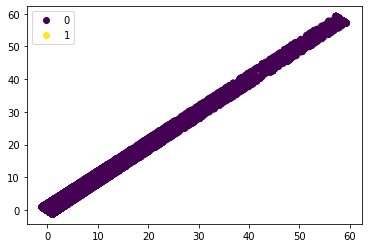

In [46]:
#plot the imbalanced dataset with PCA and Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#scale data before PCA
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)

#plot
plot = plt.scatter(Xt[:,0], Xt[:,1], c = y)
plt.legend(handles = plot.legend_elements()[0], labels = ['0', '1'])  #before labels = list(predata['is_fraud'])
plt.show()

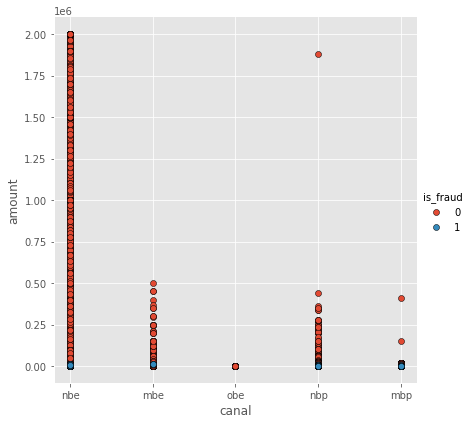

In [47]:
#plot the imbalanced dataset with seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
sns.FacetGrid(predata, hue = "is_fraud", height = 6).map(plt.scatter, "canal", "amount", edgecolor = "k").add_legend()
plt.show()

<AxesSubplot:xlabel='device', ylabel='amount'>

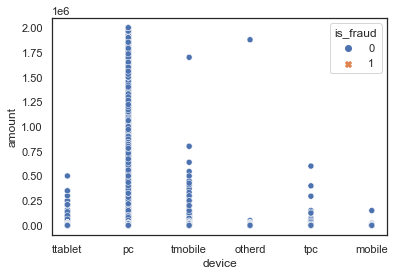

In [61]:
#plot the imbalanced dataset with seaborn

#select 2 continuous features
df = predata[['device', 'amount', 'is_fraud']]

sns.set_theme(style = 'white')

#plot
sns.scatterplot(data = df, x = 'device', y = 'amount', hue = 'is_fraud', style = 'is_fraud')

In [59]:
#plot the imbalanced dataset with TSNE and scaler
from sklearn.manifold import TSNE

#scaler
standardized_data = StandardScaler().fit_transform(predata[['weekday','amount', 'is_fraud']])

#select 50k of data
data_50k = standardized_data[0:50000]

#TSNE
tsne = TSNE(n_components = 3, verbose = 1, perplexity = 40, n_iter = 250)
data_50k_reduced = tsne.fit_transform(data_50k)

C:\Users\BeatrizCarvalho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\BeatrizCarvalho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.126s...
[t-SNE] Computed neighbors for 50000 samples in 2.545s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

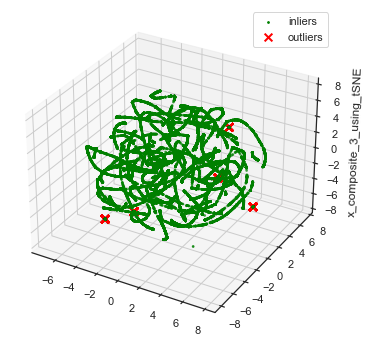

In [62]:
#plot the imbalanced dataset with TSNE and scaler - continuation
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3_using_tSNE")
ax.scatter(data_50k_reduced[:, 0], data_50k_reduced[:, 1], zs = data_50k_reduced[:, 2], s = 3, lw = 1, label = "inliers", 
           c = "green")

#outliers
out_index = [i for i in outlier_index if i <= 50000]
ax.scatter(data_50k_reduced[out_index,0],data_50k_reduced[out_index,1], data_50k_reduced[out_index,2], lw = 2, s = 60, 
           marker = "x", c = "red", label = "outliers")
ax.legend()
plt.show()

In [17]:
#view the dataframe
predata.head()

,canal,operativa,clientid,entity,reference,trusted_indicator,iban_orig,iban_dest,amount,accountbalance,ipaddress,is_fraud,browser_family,os_family,hour,week,weekday,month,device
0,nbp,trfsep,26008,3,3,0.0,26009,2717851,155.0,2216.31,87103689,1,safari,ios,16,36,3,9,ttablet
1,nbp,trfsep,134892,3,3,0.0,228118,1050074,5000.0,21666.87,1888344232,1,ie,windows,11,34,0,8,pc
2,nbp,trfint,137450,3,3,0.0,1049251,398060,3000.0,3150.00,1888344232,1,ie,windows,11,34,0,8,pc
3,nbp,trfint,223998,3,3,0.0,224000,398060,10000.0,13956.89,891521185,1,chrome,windows,10,35,4,8,pc
4,nbp,trfint,268571,3,3,0.0,268573,398060,5000.0,14862.78,1094820620,1,firefox,windows,15,33,2,8,pc


In [18]:
#change data types for columns that need to be categorical
convert_dict = {'clientid': object, 'entity': object, 'reference': object, 'iban_orig': object, 'iban_dest': object, 
                'hour': object, 'week': object, 'weekday': object, 'month': object}

predata = predata.astype(convert_dict)

In [19]:
#number of lines, null/nan values and type of each column
predata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000569 entries, 0 to 8000568
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   canal              object 
 1   operativa          object 
 2   clientid           object 
 3   entity             object 
 4   reference          object 
 5   trusted_indicator  float64
 6   iban_orig          object 
 7   iban_dest          object 
 8   amount             float64
 9   accountbalance     float64
 10  ipaddress          object 
 11  is_fraud           int64  
 12  browser_family     object 
 13  os_family          object 
 14  hour               object 
 15  week               object 
 16  weekday            object 
 17  month              object 
 18  device             object 
dtypes: float64(3), int64(1), object(15)
memory usage: 1.1+ GB


In [20]:
#balance the dataset
#undersampling -> RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler
#sampling_strategy = minority_class_data/majority_class_data 
#ex: majority = 1000, minority = 100, sampling_strategy = 0.5 -> 100/200 = 0.5 -> 200 in the majority class
under = RandomUnderSampler(sampling_strategy = 0.08)  #change for sampling_strategy = 0.00569 // total = 15638401

#oversampling -> Smote-NC
from imblearn.over_sampling import SMOTENC
                                                                    
#target column
y = predata['is_fraud']  #series

#all the other columns
X = predata.drop('is_fraud', axis = 1)  #dataframe

#specify the categorical columns for smotenc
smotenc = SMOTENC(random_state = 42, categorical_features = [X.dtypes == object])  #try k_neighbors = [1 a 7] -> default = 5

In [21]:
#pipeline
from imblearn.pipeline import Pipeline
steps = [('u', under), ('o', smotenc)]
pipeline = Pipeline(steps = steps)

In [22]:
#resample X and y 
X, y = pipeline.fit_resample(X, y)

In [23]:
#create the new dataframe
predatabalanced = X.copy()
predatabalanced['is_fraud'] = y

In [24]:
#columns of the new dataframe
predatabalanced.columns

Index(['canal', 'operativa', 'clientid', 'entity', 'reference',
       'trusted_indicator', 'iban_orig', 'iban_dest', 'amount',
       'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour',
       'week', 'weekday', 'month', 'device', 'is_fraud'],
      dtype='object')

In [25]:
#columns and rows of the new dataframe
predatabalanced.shape

(14224, 19)

In [26]:
#save the balanced dataset
predatabalanced.to_csv("2transfers_balanced_smore+rund.csv", index = False)

In [27]:
#check the new data distribution
counts_n = predatabalanced['is_fraud'].value_counts()
counts_n

0    7112
1    7112
Name: is_fraud, dtype: int64

In [28]:
#new class ratios
counts_n / predatabalanced.shape[0]

0    0.5
1    0.5
Name: is_fraud, dtype: float64

In [28]:
#profiling of the data
from pandas_profiling import ProfileReport

#ProfileReport(predata.sample(n = 10000)) for much data - it randomizes data order and selects representative sample
prof = ProfileReport(predatabalanced)             
prof.to_file(output_file = '2transfers_balanced_smote+rund.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
#select all transfers frauds after balance and save in a csv file
#transfers frauds
target_col = 'is_fraud'
frauds_transfers = predatabalanced[(predatabalanced[target_col] == 1)].copy()

#save csv file
frauds_transfers.to_csv("2frauds_transfers_balanced_smote+rund.csv", index = False)

C:\Users\BEATRI~1\AppData\Local\Temp/ipykernel_2760/2035142097.py:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


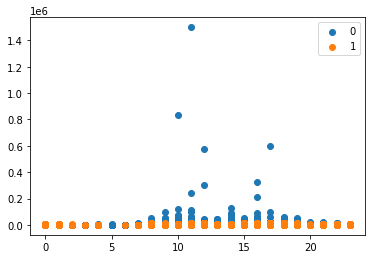

In [30]:
#plot the balanced dataset with scatter
from numpy import unique
from numpy import where
from matplotlib import pyplot 

def plot_dataset(X, y):
    
    #create scatter plot for samples from each class
    n_classes = len(unique(y))
    for class_value in range(n_classes):
        
        #get row indexes for samples with this class
        row_ix = where(y == class_value)[0]
        
        #create scatter plot of these samples
        pyplot.scatter(X.iloc[row_ix, 0], X.iloc[row_ix, 1], label = str(class_value))

    pyplot.legend()
    pyplot.show()
    
#target column
y = predatabalanced['is_fraud'] 

#columns with continuous values
X = predatabalanced[['hour', 'amount']]
       
plot_dataset(X, y)

C:\Users\BEATRI~1\AppData\Local\Temp/ipykernel_2760/1797369925.py:18: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


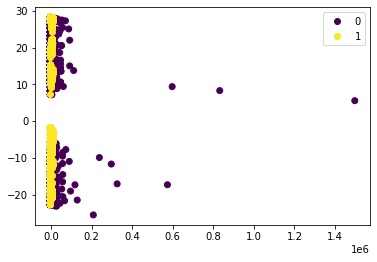

In [31]:
#plot the balanced dataset with PCA
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

#target column
y = predatabalanced['is_fraud'] 

#columns with continuous values
X = predatabalanced[['week','amount']]

#PCA
pca = PCA()
Xt = pca.fit_transform(X)

#plot
plot = plt.scatter(Xt[:,0], Xt[:,1], c = y)
plt.legend(handles = plot.legend_elements()[0], labels = ['0', '1'])  #before labels = list(predata['is_fraud'])
plt.show()

C:\Users\BEATRI~1\AppData\Local\Temp/ipykernel_2760/3437707862.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


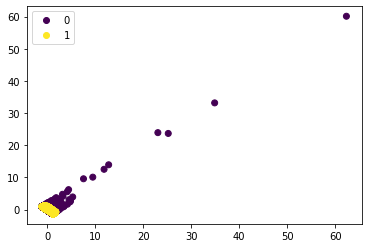

In [32]:
#plot the balanced dataset with PCA and Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#scale data before PCA
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)

#plot
plot = plt.scatter(Xt[:,0], Xt[:,1], c = y)
plt.legend(handles = plot.legend_elements()[0], labels = ['0', '1'])  #before labels = list(predata['is_fraud'])
plt.show()

C:\Users\BEATRI~1\AppData\Local\Temp/ipykernel_2760/1848475541.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


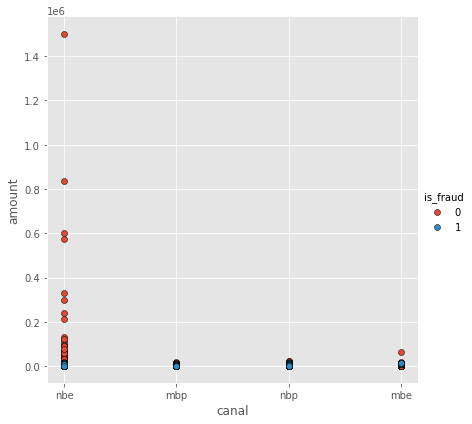

In [34]:
#plot the balanced dataset with seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
sns.FacetGrid(predatabalanced, hue = "is_fraud", height = 6).map(plt.scatter, "canal", "amount", edgecolor = "k").add_legend()
plt.show()

<AxesSubplot:xlabel='device', ylabel='amount'>

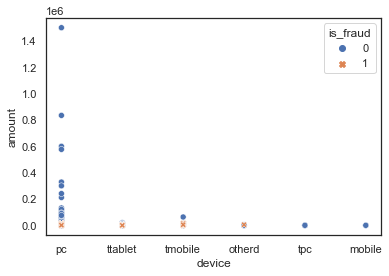

In [35]:
#plot the balanced dataset with seaborn

#select 2 continuous features
df = predatabalanced[['device', 'amount', 'is_fraud']]

sns.set_theme(style = 'white')

#plot
sns.scatterplot(data = df, x = 'device', y = 'amount', hue = 'is_fraud', style = 'is_fraud')

In [37]:
#plot the balanced dataset with TSNE and scaler
from sklearn.manifold import TSNE

#scaler
standardized_data = StandardScaler().fit_transform(predatabalanced[['weekday','amount', 'is_fraud']])

#select 50k of data
data_50k = standardized_data[0:50000]

#TSNE
tsne = TSNE(n_components = 3, verbose = 1, perplexity = 40, n_iter = 250)
data_50k_reduced = tsne.fit_transform(data_50k)

C:\Users\BeatrizCarvalho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\BeatrizCarvalho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14224 samples in 0.045s...
[t-SNE] Computed neighbors for 14224 samples in 1.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14224
[t-SNE] Computed conditional probabilities for sample 2000 / 14224
[t-SNE] Computed conditional probabilities for sample 3000 / 14224
[t-SNE] Computed conditional probabilities for sample 4000 / 14224
[t-SNE] Computed conditional probabilities for sample 5000 / 14224
[t-SNE] Computed conditional probabilities for sample 6000 / 14224
[t-SNE] Computed conditional probabilities for sample 7000 / 14224
[t-SNE] Computed conditional probabilities for sample 8000 / 14224
[t-SNE] Computed conditional probabilities for sample 9000 / 14224
[t-SNE] Computed conditional probabilities for sample 10000 / 14224
[t-SNE] Computed conditional probabilities for sample 11000 / 14224
[t-SNE] Computed conditional probabilities for sample 12000 / 14224
[t-SNE] Computed conditional probabilities for sa

NameError: name 'out_index' is not defined

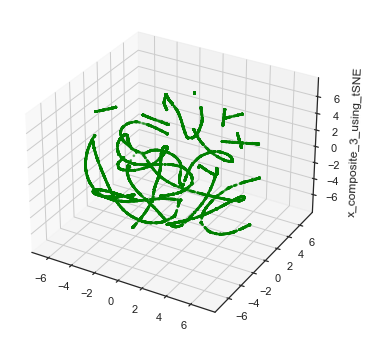

In [40]:
#plot the balanced dataset with TSNE and scaler - continuation
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3_using_tSNE")
ax.scatter(data_50k_reduced[:, 0], data_50k_reduced[:, 1], zs = data_50k_reduced[:, 2], s = 3, lw = 1, label = "inliers", 
           c = "green")

#outliers
out_index = [i for i in outlier_index if i <= 50000]
ax.scatter(data_50k_reduced[out_index,0],data_50k_reduced[out_index,1], data_50k_reduced[out_index,2], lw = 2, s = 60, 
           marker = "x", c = "red", label = "outliers")

ax.legend()
plt.show()